# Training a model with Amazon SageMaker Autopilot

In this notebook we're going to learn how to train a model with Amazon's SageMaker Autopilot. Amazon SageMaker Autopilot is an automated machine learning (commonly referred to as AutoML) solution for tabular datasets. 

First let's install the sagemaker library:

In [1]:
# tag::pip-install-sagemaker[]
!pip install sagemaker
# end::pip-install-sagemaker[]

Processing ./.cache/pip/wheels/b5/65/22/1050d5c2a082fe19ece56fbac4fe9911f79c57f5d3299e0fcb/sagemaker-2.4.1-py2.py3-none-any.whl
Processing ./.cache/pip/wheels/7b/d7/c5/488a7f8f55a2441b2c10f8a51f9d3ebf4e41389cf4fd215363/boto3-1.14.47-py2.py3-none-any.whl
  Using cached smdebug_rulesconfig-0.1.5-py2.py3-none-any.whl (6.2 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
Processing ./.cache/pip/wheels/fc/10/27/2d1e23d8b9a9013a83fbb418a0b17b1e6f81c8db8f53b53934/protobuf3_to_dict-0.1.5-py3-none-any.whl
  Using cached jmespath-0.10.0-py2.py3-none-any.whl (24 kB)
  Using cached botocore-1.17.47-py2.py3-none-any.whl (6.5 MB)
  Using cached s3transfer-0.3.3-py2.py3-none-any.whl (69 kB)
  Using cached docutils-0.15.2-py3-none-any.whl (547 kB)


In [2]:
import pandas as pd

# tag::imports[]
import sagemaker
import boto3
import os
from time import gmtime, strftime, sleep
# end::imports[]

Let's first load the features that we engineered in the previous notebook:

In [3]:
# Load the CSV files saved in the train/test notebook

# tag::load-csv-files[]
df_train_under = pd.read_csv("data/df_train_under_all.csv")
df_test_under = pd.read_csv("data/df_test_under_all.csv")
# end::load-csv-files[]

m = {1: 'yes',0: 'no'} 

df_train_under["label"] = df_train_under["label"].map(m)
df_test_under["label"] = df_test_under["label"].map(m)

In [4]:
# tag::train-features[]
df_train_under.drop(columns=["node1", "node2"]).sample(5, random_state=42)
# end::train-features[]

,cn,maxCoefficient,maxTriangles,minCoefficient,minTriangles,pa,sl,sp,tn,label
116159,4.0,1.0,10,1.000000,10,25.0,1.0,1.0,6.0,yes
107109,2.0,1.0,3,0.333333,2,12.0,1.0,1.0,5.0,yes
82258,2.0,1.0,3,1.000000,3,9.0,1.0,1.0,4.0,yes
79773,0.0,1.0,10,1.000000,3,15.0,0.0,1.0,8.0,no
42367,0.0,1.0,5,0.833333,1,8.0,0.0,1.0,6.0,no


In [5]:
# tag::test-features[]
df_test_under.drop(columns=["node1", "node2"]).sample(5, random_state=42)
# end::test-features[]

,cn,maxCoefficient,maxTriangles,minCoefficient,minTriangles,pa,sl,sp,tn,label
35910,0.0,1.000000,28,0.866667,14,48.0,0.0,0.0,14.0,no
98339,3.0,0.068908,38,0.058480,8,665.0,0.0,0.0,51.0,yes
147201,1.0,0.333333,1,0.000000,0,6.0,1.0,1.0,4.0,yes
126570,4.0,0.377778,27,0.152047,18,190.0,0.0,0.0,25.0,yes
124563,2.0,0.666667,2,0.300000,1,15.0,1.0,1.0,6.0,yes


In [6]:
# tag::prerequisites[]
boto_session = boto3.Session(
    aws_access_key_id=os.environ["ACCESS_ID"],
    aws_secret_access_key= os.environ["ACCESS_KEY"])

region = boto_session.region_name

session = sagemaker.Session(boto_session=boto_session)
bucket = session.default_bucket()

timestamp_suffix = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
# timestamp_suffix = "2020-08-20-11-26-33"

prefix = 'sagemaker/link-prediction-developer-guide-' + timestamp_suffix

role = os.environ["SAGEMAKER_ROLE"]

sm = boto_session.client(service_name='sagemaker',region_name=region)
# end::prerequisites[]

## Upload the dataset to Amazon S3

Copy the file to Amazon Simple Storage Service (Amazon S3) in a .csv format for Amazon SageMaker training to use.

In [7]:
# tag::upload-dataset-s3[]
train_columns = [
    "cn", "pa", "tn", "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", "sp", "sl", "label"
]
df_train_under = df_train_under[train_columns]

test_columns = [
    "cn", "pa", "tn", "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", "sp", "sl"
]
df_test_under = df_test_under.drop(columns=["label"])[test_columns]

train_file = 'data/upload/train_data_yesno.csv';
df_train_under.to_csv(train_file, index=False, header=True)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")
print('Train data uploaded to: ' + train_data_s3_path)

test_file = 'data/upload/test_data_yesno.csv';
df_test_under.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")
print('Test data uploaded to: ' + test_data_s3_path)
# end::upload-dataset-s3[]

Train data uploaded to: s3://sagemaker-us-east-1-715633473519/sagemaker/link-prediction-developer-guide-2020-08-21-16-55-41/train/train_data_yesno.csv
Test data uploaded to: s3://sagemaker-us-east-1-715633473519/sagemaker/link-prediction-developer-guide-2020-08-21-16-55-41/test/test_data_yesno.csv


## Setting up the SageMaker Autopilot Job

Now that we've uploaded the dataset to S3, we're going to call Autopilot and have it find the best model for the dataset. Autopilot's required inputs are as follows:

* Amazon S3 location for input dataset and for all output artifacts
* Name of the column of the dataset you want to predict (`label` in this case) 
* An IAM role

The training CSV file that we send to Autopilot should have a header row.

In [8]:
# tag::autopilot-setup[]
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': 's3://{}/{}/train'.format(bucket,prefix)
        }
      },
      'TargetAttributeName': 'label'
    }
  ]

automl_job_config = {
    "CompletionCriteria": {
        "MaxRuntimePerTrainingJobInSeconds": 300,
        "MaxCandidates": 5,
    }
}

output_data_config = {
    'S3OutputPath': 's3://{}/{}/output'.format(bucket,prefix)
  }
# end::autopilot-setup[]

## Launching the SageMaker Autopilot Job

We can now launch the Autopilot job by calling the `create_auto_ml_job` API. 

In [9]:
# tag::autopilot-launch[]
auto_ml_job_name = 'automl-link-' + timestamp_suffix
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      ProblemType="BinaryClassification",
                      AutoMLJobObjective={"MetricName": "Accuracy"},
                      AutoMLJobConfig=automl_job_config,
                      RoleArn=role)
# end::autopilot-launch[]

AutoMLJobName: automl-link-2020-08-21-16-55-41


{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:715633473519:automl-job/automl-link-2020-08-21-16-55-41',
 'ResponseMetadata': {'RequestId': '74473543-bfec-4965-b4f6-93cd96545b5c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '74473543-bfec-4965-b4f6-93cd96545b5c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '102',
   'date': 'Fri, 21 Aug 2020 16:58:04 GMT'},
  'RetryAttempts': 0}}

### Tracking SageMaker Autopilot job progress

SageMaker Autopilot job consists of the following high-level steps : 

* Analyzing Data, where the dataset is analyzed and Autopilot comes up with a list of ML pipelines that should be tried out on the dataset. The dataset is also split into train and validation sets.
* Feature Engineering, where Autopilot performs feature transformation on individual features of the dataset as well as at an aggregate level.
* Model Tuning, where the top performing pipeline is selected along with the optimal hyperparameters for the training algorithm (the last stage of the pipeline). 

In [11]:
print ('JobStatus - Secondary Status')
print('------------------------------')

# auto_ml_job_name = "automl-link-2020-08-20-11-26-33"

# tag::autopilot-track-progress[]
describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)
# end::autopilot-track-progress[]

JobStatus - Secondary Status
------------------------------
Completed - MaxCandidatesReached


In [12]:
# tag::autopilot-all-candidates[]
candidates = sm.list_candidates_for_auto_ml_job(
    AutoMLJobName=auto_ml_job_name, 
    SortBy='FinalObjectiveMetricValue')['Candidates']

candidates_df = pd.DataFrame({
    "name": [c["CandidateName"] for c in candidates],
    "score": [c["FinalAutoMLJobObjectiveMetric"]["Value"] for c in candidates]
})
candidates_df
# end::autopilot-all-candidates[]

display(candidates_df)
candidates_df.to_csv("data/autopilot_candidates.csv", index=False, float_format='%g')

,name,score
0,tuning-job-1-3cae959555544c58aa-001-42b5b386,0.965170
1,tuning-job-1-3cae959555544c58aa-004-f37e4b5b,0.926750
2,tuning-job-1-3cae959555544c58aa-002-304105c0,0.912544
3,tuning-job-1-3cae959555544c58aa-003-3943761a,0.907270
4,tuning-job-1-3cae959555544c58aa-005-6a44db8f,0.907210


In [13]:
# tag::autopilot-best-candidate[]
best_candidate = sm.describe_auto_ml_job(
    AutoMLJobName=auto_ml_job_name)['BestCandidate']

best_df = pd.DataFrame({
    "name": [best_candidate['CandidateName']],
    "metric": [best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName']],
    "score": [best_candidate['FinalAutoMLJobObjectiveMetric']['Value']]
})
best_df
# end::autopilot-best-candidate[]

display(best_df)
best_df.to_csv("data/autopilot_best_candidate.csv", index=False, float_format='%g')

,name,metric,score
0,tuning-job-1-3cae959555544c58aa-001-42b5b386,validation:accuracy,0.96517


### Perform batch inference using the best candidate

Now that we have successfully completed the SageMaker Autopilot job on the dataset, create a model from any of the candidates by using [Inference Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/inference-pipelines.html). 

In [14]:
# timestamp_suffix = "automl-link-2020-08-20-09-25-03"

# tag::autopilot-create-model[]
model_name = 'automl-link-pred-model-' + timestamp_suffix

model = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Model ARN corresponding to the best candidate is : {}'.format(model['ModelArn']))
# end::autopilot-create-model[]

Model ARN corresponding to the best candidate is : arn:aws:sagemaker:us-east-1:715633473519:model/automl-link-pred-model-2020-08-21-16-55-41


### Evaluating the model

And now we're going to create a transform job based on this model.
A transform job uses a trained model to get inferences on a dataset and saves these results to S3.

In [15]:
# test_data_s3_path = "s3://sagemaker-us-east-1-715633473519/sagemaker/link-prediction-developer-guide-2020-08-20-11-26-33/train/train_data_copy.csv"
# timestamp_suffix = "2020-08-20-11-26-33"
# timestamp_suffix = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

# tag::autopilot-create-transform-job[]
transform_job_name = 'automl-link-pred-transform-job-' + timestamp_suffix

print(test_data_s3_path, transform_job_name, model_name)

transform_input = {
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': test_data_s3_path
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    }

transform_output = {
        'S3OutputPath': 's3://{}/{}/inference-results'.format(bucket,prefix),
    }

transform_resources = {
        'InstanceType': 'ml.m5.4xlarge',
        'InstanceCount': 1
    }

sm.create_transform_job(TransformJobName = transform_job_name,
                        ModelName = model_name,
                        TransformInput = transform_input,
                        TransformOutput = transform_output,
                        TransformResources = transform_resources
)
# end::autopilot-create-transform-job[]

s3://sagemaker-us-east-1-715633473519/sagemaker/link-prediction-developer-guide-2020-08-21-16-55-41/test/test_data_yesno.csv automl-link-pred-transform-job-2020-08-21-16-55-41 automl-link-pred-model-2020-08-21-16-55-41


{'TransformJobArn': 'arn:aws:sagemaker:us-east-1:715633473519:transform-job/automl-link-pred-transform-job-2020-08-21-16-55-41',
 'ResponseMetadata': {'RequestId': '8225c08d-7cb0-4a4f-a961-743a2509fc62',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8225c08d-7cb0-4a4f-a961-743a2509fc62',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '127',
   'date': 'Fri, 21 Aug 2020 20:49:37 GMT'},
  'RetryAttempts': 0}}

In [16]:
print ('JobStatus')
print('----------')

# tag::autopilot-track-transform-job[]
describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
job_run_status = describe_response['TransformJobStatus']
print (job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
    job_run_status = describe_response['TransformJobStatus']
    print (job_run_status)
    sleep(30)
# end::autopilot-track-transform-job[]    

print(describe_response)

JobStatus
----------
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
{'TransformJobName': 'automl-link-pred-transform-job-2020-08-21-16-55-41', 'TransformJobArn': 'arn:aws:sagemaker:us-east-1:715633473519:transform-job/automl-link-pred-transform-job-2020-08-21-16-55-41', 'TransformJobStatus': 'Completed', 'ModelName': 'automl-link-pred-model-2020-08-21-16-55-41', 'TransformInput': {'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-715633473519/sagemaker/link-prediction-developer-guide-2020-08-21-16-55-41/test/test_data_yesno.csv'}}, 'ContentType': 'text/csv', 'CompressionType': 'None', 'SplitType': 'Line'}, 'TransformOutput': {'S3OutputPath': 's3://sagemaker-us-east-1-715633473519/sagemaker/link-prediction-developer-guide-2020-08-21-16-55-41/inference-results', 'AssembleWith': 'None', 'KmsKeyId': ''}, 'TransformResources': {'InstanceType': 'ml.m5.4xlarge', 'Inst

Now let's view the results of the transform job:

In [72]:
# tag::autopilot-transform-job-results[]
s3_output_key = '{}/inference-results/train_data_copy.csv.out'.format(prefix);
local_inference_results_path = 'data/inference_results.csv'

inference_results_bucket = boto_session.resource("s3").Bucket(session.default_bucket())
inference_results_bucket.download_file(s3_output_key, local_inference_results_path);

data = pd.read_csv(local_inference_results_path, sep=';', header=None)
data.sample(10, random_state=42)
# end::autopilot-transform-job-results[]

,0
35910,0
98339,0
147201,0
126570,0
124563,0
12074,0
52357,0
93365,0
106125,0
58767,0


In [78]:
# tag::evaluation-imports[]
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
# end::evaluation-imports[]

# tag::evaluation-functions[]
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })
# end::evaluation-functions[]

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

In [79]:
# tag::test-model[]
predictions = data[0]
y_test = df_test_under["label"]

evaluate_model(y_test, predictions)
# end::test-model[]

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Measure,Score
0,Accuracy,0.5
1,Precision,0.0
2,Recall,0.0


In [16]:
evaluate_model(predictions, y_test).to_csv("data/sagemaker-model-eval.csv", index=False)

'Feature Importance'

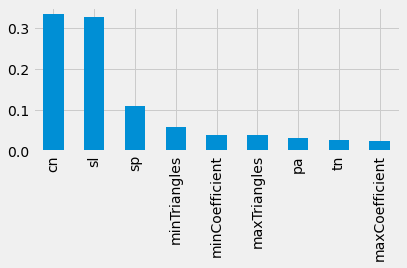

In [12]:
feature_importance(columns, classifier)